# Custom Datasets

## Abstract

In this notebook, a structured image dataset (not a PyTorch built-in dataset) imported with torchvision and trained a CNN model to perform classification. Later the same model trained with same dataset but applied data augmentation.

Used `torchvision.datasets.ImageFolder` for importing dataset and augmented with `transforms.TrivialAugmentWide()` using maximum augmentation intensity.

## Imports

In [1]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms

In [2]:
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

PyTorch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


## Dataset to Import

An undersampled version of [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset by Daniel Bourke. Used a partition of dataset for faster train times while experimenting.

In [3]:
from helper_functions import download_data

data_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi")

[INFO] data\pizza_steak_sushi directory exists, skipping download.


### Investigate Data

In [4]:
data_path

WindowsPath('data/pizza_steak_sushi')

<pre>
pizza_steak_sushi
    ┣━test
        ┣━pizza
        ┣━steak
        ┗━sushi
    ┗━train
        ┣━pizza
        ┣━steak
        ┗━sushi
</pre>

In [5]:
import os

for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"In path {dirpath}, found {len(dirnames)} directories, and {len(filenames)} files.")

In path data\pizza_steak_sushi, found 2 directories, and 0 files.
In path data\pizza_steak_sushi\test, found 3 directories, and 0 files.
In path data\pizza_steak_sushi\test\pizza, found 0 directories, and 25 files.
In path data\pizza_steak_sushi\test\steak, found 0 directories, and 19 files.
In path data\pizza_steak_sushi\test\sushi, found 0 directories, and 31 files.
In path data\pizza_steak_sushi\train, found 3 directories, and 0 files.
In path data\pizza_steak_sushi\train\pizza, found 0 directories, and 78 files.
In path data\pizza_steak_sushi\train\steak, found 0 directories, and 75 files.
In path data\pizza_steak_sushi\train\sushi, found 0 directories, and 72 files.


Visualizing random images from dataset.

(-0.5, 511.5, 511.5, -0.5)

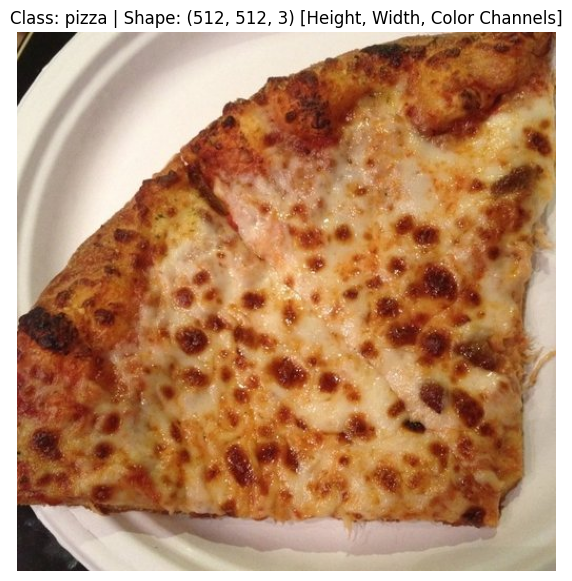

In [6]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# random.seed(7)

# glob() takes a pattern as parameter
# *.jpg     -> files with jpg extension
# */*.jpg   -> files with jpg extension in sub folders
# */*/*.jpg -> files with jpg extension in sub folders within second degree sub-folders
# Essentially "get every .jpg under data/pizza_steak_sushi/"
image_paths = list(data_path.glob("*/*/*.jpg"))

# Randomly select one item from path list and get it's folder name too
random_image_path = random.choice(image_paths)
random_image_class = random_image_path.parent.stem

# Open jpg file as PIL Image
image = Image.open(random_image_path)

# Convert PIL image to numpy array
np_image = np.asarray(image)

# Plot numpy array with matplotlib
plt.figure(figsize=(7, 7))
plt.title(f"Class: {random_image_class} | Shape: {np_image.shape} [Height, Width, Color Channels]")
plt.imshow(np_image)
plt.axis(False)

### Importing to PyTorch

Again [TinyVGG](https://poloclub.github.io/cnn-explainer/) model will be used for this experimentation. TinyVGG model expects a 64x64 input so input is resized accordingly. Our images are read as PIL images. We need to convert them to torch tensors. Also normalizing applied for faster training along with bunch of positive effects.

In [7]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToImage(), 
    transforms.ToDtype(dtype=torch.float32, scale=True),
])

A helper method for observing before and after applying transformations to our dataset.

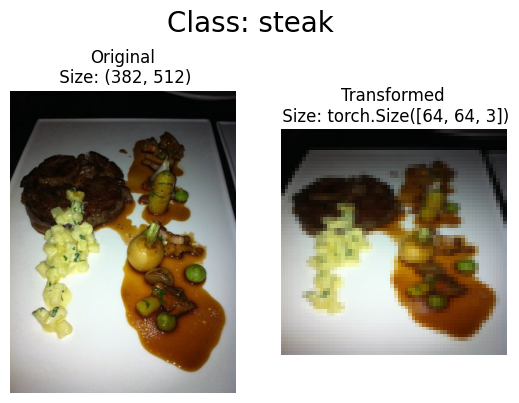

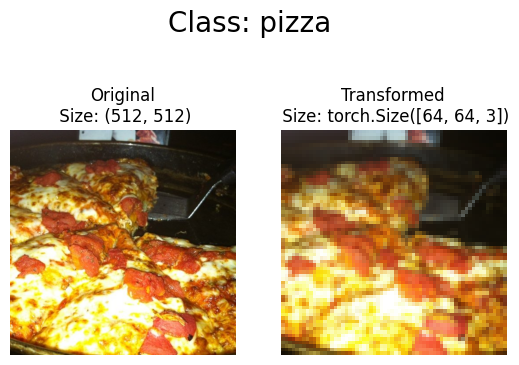

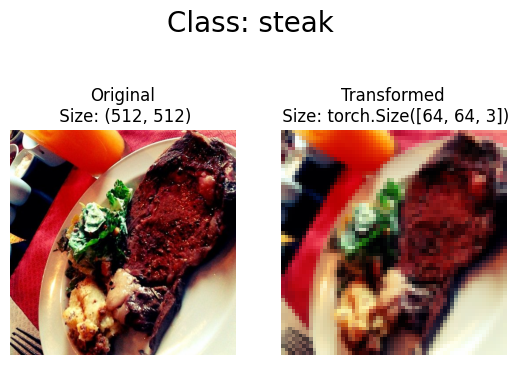

In [8]:
def plot_transformed(data_path:list, transform, num_samples=3, seed=None):
    """
    Plots number of images from image paths before and after transformation.
    """
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(population=data_path, k=num_samples)

    for image_path in random_image_paths:
        with Image.open(image_path) as i:
            fig, ax = plt.subplots(1, 2)

            # Set Original images as left column
            ax[0].set_title(f"Original\n Size: {i.size}")
            ax[0].imshow(i)
            ax[0].axis(False)

            # transform the data and arrange color channel to last
            transformed = transform(i).permute(1, 2, 0)

            # Set transformed images as right column and show like 
            # [original image] -> [transformed image]
            ax[1].set_title(f"Transformed\n Size: {transformed.shape}")
            ax[1].imshow(transformed)
            ax[1].axis(False)

            # Set figure related options
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=20)


plot_transformed(image_paths, transform=data_transform, seed=7)

Creating the image paths with `torchvision.datasets.ImageFolder`. ImageFolder expects a folder structure just like our dataset. If a dataset is not in a format PyTorch expects, a new one can be created sub-classing appropriate `data.Dataset` class. For this case we do not need.

As well as importing file paths with `ImageFolder`, data can eb transformed in various ways like: resizing, cropping, converting to tensor, changing data type, normalizing etc. 

In [9]:
train_dir = data_path / "train"
test_dir = data_path / "test"

train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=data_transform)

test_dataset = datasets.ImageFolder(root=test_dir,
                                     transform=data_transform)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToImage()
                  ToDtype(scale=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToImage()
                  ToDtype(scale=True)
            ))

Taking a look at some properties of ImageFolder. Notice that it has the same properties with example in [computer vision](computer-vision.ipynb) example. Because both dataset generators inherits the same properties from `torch.data.dataset`.

In [10]:
len(train_dataset), len(test_dataset)

(225, 75)

In [11]:
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [12]:
class_dict = train_dataset.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

We can check that indeed the dataset is [0-1] normalized.

In [36]:
img1, lbl1 = train_dataset[0]
img2, lbl2 = test_dataset[0]

torch.min(img1), torch.max(img1), torch.min(img2), torch.max(img2)

(tensor(0.), tensor(1.), tensor(0.), tensor(0.9804))

Batching the dataset using `torch.data.DataLoader`.

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


## Device Agnostic Code

Use CUDA acceleration if possible. Else fallback to CPU.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Create Model

Below class contains the PyTorch implementation of TinyVGG.

In [16]:
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self,
                 in_channels, 
                 out_features, 
                 hidden_units=10):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=13*13*hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.linear(self.conv_block_2(self.conv_block_1(x)))
    
torch.manual_seed(7)
torch.cuda.manual_seed(7)
model1 = TinyVGG(in_channels=3, out_features=len(class_names)).to(device)

model1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Making a dummy forward pass to determine the output shape of convolutional layer.

In [17]:
img, label = train_dataset[0]

# IMPORTANT: Do not forget to add batch size to input shape
# if a dummy forward pass is performed.
img = img.unsqueeze(0)
print(img.shape)
img = img.to(device)

model1.eval()
with torch.inference_mode():
    model1(img)

torch.Size([1, 3, 64, 64])


Or use `torchinfo` for getting a good look of the model. Check their repo for more instructions and advanced use cases: https://github.com/TylerYep/torchinfo

In [18]:
import torchinfo

torchinfo.summary(model=model1, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Training

Creating a loss function and optimizer for training. `nn.CrossEntropyLoss()` is used as loss function for multiclass classification purpose.

In [19]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

Train and test epoch methods. Then combined in single `train()` function.

In [20]:
def train_single_epoch(dataloader:torch.utils.data.DataLoader, 
                       loss_fn:nn.Module, 
                       acc_fn, 
                       model:nn.Module, 
                       optimizer:torch.optim.Optimizer,
                       device:str):
    # Set model to train mode
    model.train()

    # loss and accuracy per batch
    total_loss, total_acc = 0, 0 

    for batch, (X, y) in enumerate(dataloader):
        # Relocate data to device
        X, y = X.to(device), y.to(device)
        
        # Clear accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(X)

        # Calculate the loss
        loss = loss_fn(logits, y)
        total_loss += loss

        # Calculate the accuracy
        y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
        acc = acc_fn(y, y_preds)
        total_acc += acc

        # Backpropagate
        loss.backward()

        # Update the gradients
        optimizer.step()

    total_loss /= len(dataloader)
    total_acc /= len(dataloader)

    return total_loss, total_acc



def test_single_epoch(dataloader:torch.utils.data.DataLoader, 
                      loss_fn:nn.Module, 
                      acc_fn, 
                      model:nn.Module,
                      device:str):
    total_loss, total_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Relocate data to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            logits = model(X)

            # Calculate the loss
            total_loss += loss_fn(logits, y)

            # Calculate the accuracy
            y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
            total_acc += acc_fn(y, y_preds) 

        total_loss /= len(dataloader)
        total_acc /= len(dataloader)

    return total_loss, total_acc


def train(train_dataloader, test_dataloader, loss_fn, acc_fn, model, epochs, device):
    # Keep train results 
    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    # For text formatting purposes
    PAD = len(str(epochs))

    # Send model to device
    model.to(device)
    
    for epoch in range(1, epochs+1):
        train_loss, train_acc = train_single_epoch(dataloader=train_dataloader,
                           loss_fn=loss_fn,
                           acc_fn=acc_fn,
                           model=model,
                           optimizer=optimizer,
                           device=device
                           )
        
        test_loss, test_acc = test_single_epoch(dataloader=test_dataloader,
                           loss_fn=loss_fn,
                           acc_fn=acc_fn,
                           model=model,
                           device=device
                           )
    
        print(
            f"Epoch: {epoch:>{PAD}} | "
            f"Train Loss: {train_loss:.5f} | "
            f"Train Accuracy: {train_acc:.5f} | "
            f"Test Loss: {test_loss:.5f} | "
            f"Test Accuracy {test_acc:.5f}"
            )
        
        history["train_loss"].append(train_loss.item() if isinstance(
            train_loss, torch.Tensor) else train_loss)
        
        history["train_acc"].append(train_acc.item() if isinstance(
            train_acc, torch.Tensor) else train_acc)
        
        history["test_loss"].append(test_loss.item() if isinstance(
            test_loss, torch.Tensor) else test_loss)
        
        history["test_acc"].append(test_acc.item() if isinstance(
            test_acc, torch.Tensor) else test_acc)
        
    return history

Start training model. We can see that TinyVGG trained for 20 epochs reached around 60% accuracy. Can be improved with various techniques like: training for longer, adjusting the model, data augmentation, transfer learning. All of them or some combinations of them can be experimented upon.

In [21]:
from helper_functions import accuracy_fn

torch.manual_seed(7)
torch.cuda.manual_seed(7)

model1_history = train(train_dataloader=train_dataloader, 
                       test_dataloader=test_dataloader, 
                       loss_fn=loss_fn, 
                       acc_fn=accuracy_fn, 
                       model=model1, 
                       epochs=20,
                       device=device)

Epoch:  1 | Train Loss: 1.11661 | Train Accuracy: 27.34375 | Test Loss: 1.12083 | Test Accuracy 19.79167
Epoch:  2 | Train Loss: 1.08243 | Train Accuracy: 44.14062 | Test Loss: 1.12855 | Test Accuracy 26.04167
Epoch:  3 | Train Loss: 1.11856 | Train Accuracy: 30.46875 | Test Loss: 1.13163 | Test Accuracy 26.04167
Epoch:  4 | Train Loss: 1.08240 | Train Accuracy: 42.57812 | Test Loss: 1.13637 | Test Accuracy 27.08333
Epoch:  5 | Train Loss: 1.07578 | Train Accuracy: 47.26562 | Test Loss: 1.13033 | Test Accuracy 27.08333
Epoch:  6 | Train Loss: 1.02182 | Train Accuracy: 58.59375 | Test Loss: 1.11094 | Test Accuracy 25.00000
Epoch:  7 | Train Loss: 0.96510 | Train Accuracy: 62.10938 | Test Loss: 1.04398 | Test Accuracy 39.20455
Epoch:  8 | Train Loss: 0.96396 | Train Accuracy: 52.73438 | Test Loss: 1.05987 | Test Accuracy 36.17424
Epoch:  9 | Train Loss: 1.04092 | Train Accuracy: 53.51562 | Test Loss: 1.00970 | Test Accuracy 47.34848
Epoch: 10 | Train Loss: 0.83907 | Train Accuracy: 61.71

Visualize the results for better understanding. we can see that model is fluctuating a bit but actually learning our dataset. Accuracy is rising and loss getting lower. But if we look closer we can see that model is actually overfitting a bit. Train accuracy is getting higher without test accuracy not rising. Also train loss is far lower than test loss.

Overfitting can be eliminated to some degree by applying regularization techniques and augmenting the dataset. Also techniques mentioned before can help too. Whichever will be better suited for this dataset is, again, can be decided with experimentation. 

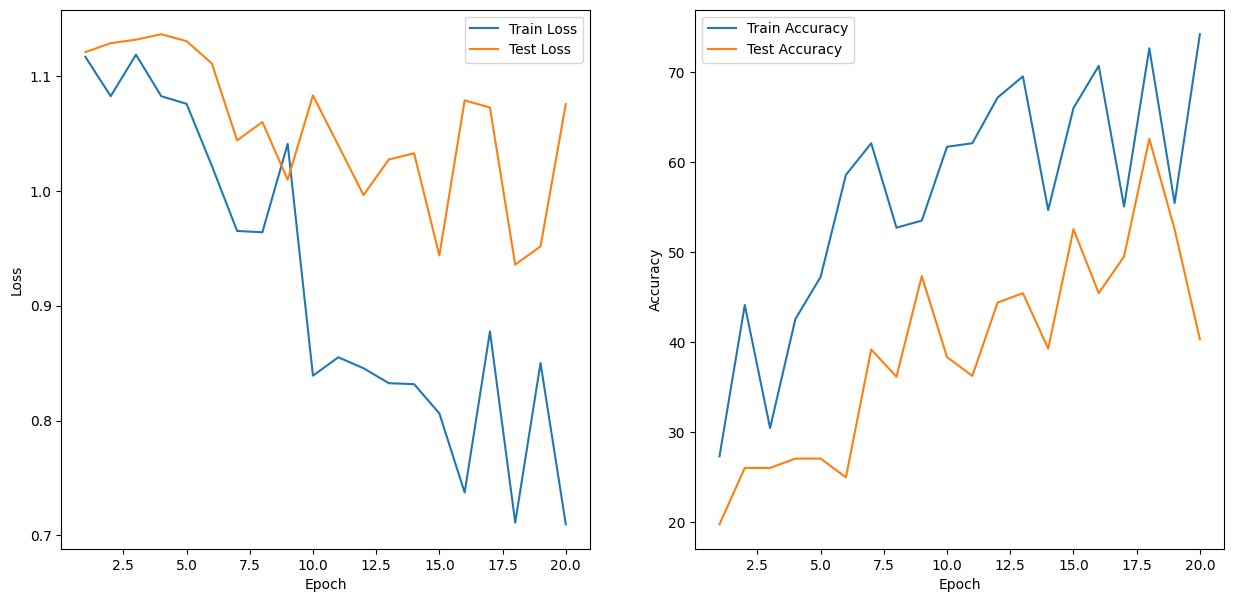

In [22]:
def plot_history(history:dict):
    epochs = range(1, len(history["test_acc"])+1)

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["test_acc"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


plot_history(model1_history)

## Data Augmentation

Let's test if augmentation helps for this case. Many alterations can de made to the input considered as augmentation For all the operations already supported by Pytorch see https://pytorch.org/vision/0.20/transforms.html

In this example not a specific and static pipeline used for augmentation. Instead, used the PyTorch implementation of method called Trivial Augment which helped PyTorch team train state-of-the-art computer vision model. For more info, see [docs](https://pytorch.org/vision/0.20/generated/torchvision.transforms.v2.TrivialAugmentWide.html#torchvision.transforms.v2.TrivialAugmentWide) and see [their training steps](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/).

Augmentation is only applied to train data. Test data only resized, converted to tensor and normalized as usual.

In [ ]:
augmentation_train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToImage(),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToDtype(dtype=torch.float32, scale=True),
])

augmentation_test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToImage(),
    transforms.ToDtype(dtype=torch.float32, scale=True),
])

Creating the dataset paths along with augmentation pipeline.

In [24]:
# train_dir = data_path / "train"
# test_dir = data_path / "test"

augmented_train_dataset = torchvision.datasets.ImageFolder(root=train_dir,
                                                           transform=augmentation_train_transform)

augmented_test_dataset = torchvision.datasets.ImageFolder(root=test_dir,
                                                          transform=augmentation_test_transform)

augmented_train_dataset, augmented_test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToImage()
                  TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=31)
                  ToDtype(scale=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToImage()
                  ToDtype(scale=True)
            ))

Observe that augmentation steps like rotations and color channel changes applied to some degree. If you are not satisfied with the results or try to adjust some change the `num_magnitude_bins` parameter in `transforms.TrivialAugmentWide()`. But be aware, the parameter only accepts values 0 to 31. 0 for less likelihood of applying augmentation, 31 fo the most intense.

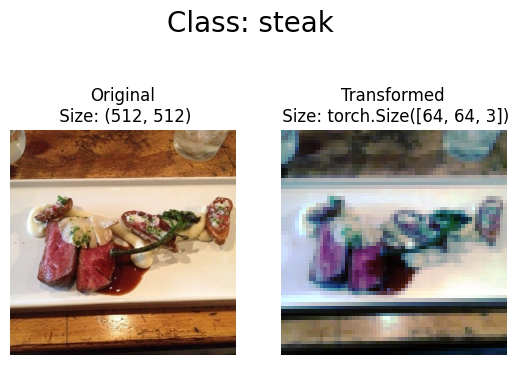

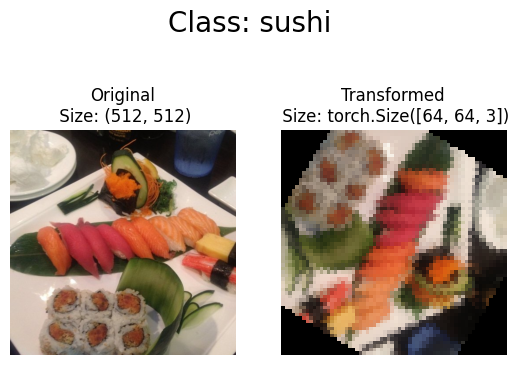

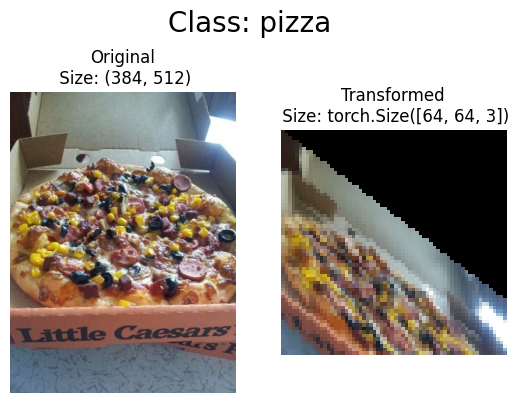

In [38]:
plot_transformed(image_paths, transform=augmentation_train_transform)

From now on steps ae the same:
1. Batch the dataset
2. Instance the model
3. Select loss function
4. Select optimizer and set parameters.
5. Train the model
6. Plot the results (optional)

Epoch:  1 | Train Loss: 1.11626 | Train Accuracy: 27.34375 | Test Loss: 1.12076 | Test Accuracy 19.79167
Epoch:  2 | Train Loss: 1.10738 | Train Accuracy: 29.29688 | Test Loss: 1.12390 | Test Accuracy 26.04167
Epoch:  3 | Train Loss: 1.09889 | Train Accuracy: 30.46875 | Test Loss: 1.12646 | Test Accuracy 26.04167
Epoch:  4 | Train Loss: 1.10526 | Train Accuracy: 31.25000 | Test Loss: 1.12163 | Test Accuracy 19.79167
Epoch:  5 | Train Loss: 1.10608 | Train Accuracy: 28.51562 | Test Loss: 1.10090 | Test Accuracy 18.75000
Epoch:  6 | Train Loss: 1.09513 | Train Accuracy: 39.45312 | Test Loss: 1.10512 | Test Accuracy 19.79167
Epoch:  7 | Train Loss: 1.09629 | Train Accuracy: 30.07812 | Test Loss: 1.10357 | Test Accuracy 20.83333
Epoch:  8 | Train Loss: 1.08789 | Train Accuracy: 51.56250 | Test Loss: 1.07724 | Test Accuracy 55.30303
Epoch:  9 | Train Loss: 1.04954 | Train Accuracy: 51.17188 | Test Loss: 1.03207 | Test Accuracy 60.41667
Epoch: 10 | Train Loss: 1.03828 | Train Accuracy: 33.98

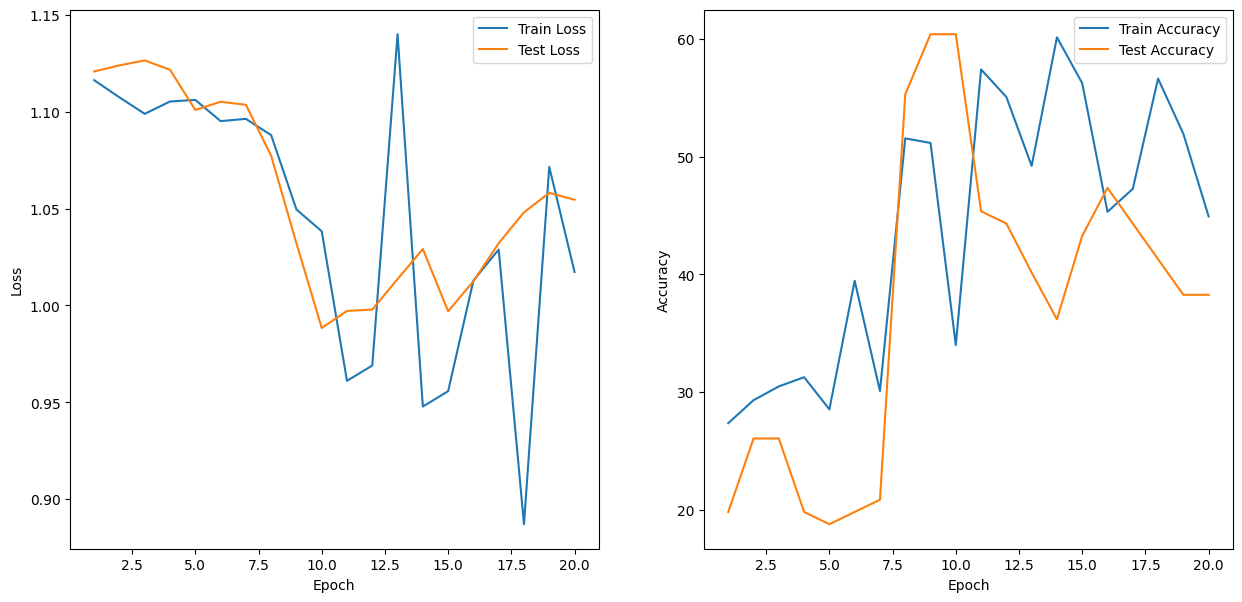

In [26]:
augmented_train_dataloader = DataLoader(dataset=augmented_train_dataset,
                                        batch_size=32,
                                        shuffle=True,
                                        )

augmented_test_dataloader = DataLoader(dataset=augmented_test_dataset,
                                       batch_size=32,
                                       shuffle=False,
                                       )

torch.manual_seed(7)
torch.cuda.manual_seed(7)
model2 = TinyVGG(in_channels=3, out_features=len(class_names)).to(device)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

torch.manual_seed(7)
torch.cuda.manual_seed(7)

model2_history = train(train_dataloader=augmented_train_dataloader, 
                       test_dataloader=augmented_test_dataloader,
                       loss_fn=loss_fn, 
                       acc_fn=accuracy_fn, 
                       model=model2, 
                       epochs=20,
                       device=device)

plot_history(model2_history)

As you can see, this time results are all over the place. But one positive thing to note is 60% accuracy reached almost at the half of the time compared to non-augmented model train.

As a side effect (probably model reaching it's representing power for our dataset) model overfit started earlier. As a precaution to that, early stopping can be used along with other techniques mentioned above.